<a href="https://colab.research.google.com/github/satvik-dixit/feature_importance/blob/main/emodb_next.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CKA Speech Emotion Recognition Demo

A demo containing all steps of speech emotion recoginition using the EmoDB dataset. The demo has been divided into 3 phases:
- Phase 1: Loading audio files and extracting metadata
- Phase 2: Embedding Extraction
- Phase 3: CKA



### Importing packages

In [31]:

!git clone -q https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -q -e ./serab-byols

!pip install -q tqdm==4.60.0
!pip install -q opensmile

fatal: destination path 'serab-byols' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done


In [ ]:
# code to restart runtime so the packages get installed
import os
os.kill(os.getpid(), 9)

In [1]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from random import sample

import librosa
import soundfile as sf

import torch
import opensmile
import serab_byols

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


In [2]:
! pip install -q kaggle

from google.colab import files
files.upload()

# Name directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


# Phase 1: Loading audio files and extracting metadata

Includes downloading the dataset, loading audio files, resampling audio files, extracting metadata



### Defining a function for loading and resampling audio files

In [3]:
# Defining a function for loading and resampling audio files

def load_audio_files(audio_files, resampling_frequency=16000, audio_list=None):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''
  # Making audio_list
  if audio_list is None:
    audio_list = []

  # Resampling
  for audio in audio_files:
    signal, fs = librosa.load(audio, sr=resampling_frequency)
    audio_list.append(torch.from_numpy(signal))
      
  return audio_list
        

### Loading and resampling audiofiles and collecting metadata on EmoDB dataset

In [4]:
# Phase_1
# Load dataset
! kaggle datasets download -q -d piyushagni5/berlin-database-of-emotional-speech-emodb
! unzip -q berlin-database-of-emotional-speech-emodb.zip

# Load and resample audio files
audio_files = glob(os.path.join('/content/wav','*.wav'))
audio_list= load_audio_files(audio_files, resampling_frequency=16000)

# Making speakers list and labels list 
speakers = []
labels = []
for audio_file in audio_files:
  file_name = audio_file.split('/')[3]
  speakers.append(int(file_name[:2]))
  labels.append(file_name[5:6])


# Verify phase_1
print('Number of audio files: {}'.format(len(audio_list)))
print('Number of speaker classes: {}'.format(len(set(speakers))))
print('Speaker classes: {}'.format(set(speakers)))
print('Number of speakers: {}'.format(len(speakers)))
print('Number of label classes: {}'.format(len(set(labels))))
print('Label classes: {}'.format(set(labels)))
print('Number of labels: {}'.format(len(labels)))

replace wav/03a01Fa.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Number of audio files: 535
Number of speaker classes: 10
Speaker classes: {3, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Number of speakers: 535
Number of label classes: 7
Label classes: {'T', 'L', 'F', 'E', 'W', 'A', 'N'}
Number of labels: 535


### OpenSMILE feature categories

In [5]:
# Color code ticklabels

vocal_folds = 'dodgerblue'
intensity = 'limegreen'
vocal_tract = 'crimson'
spectral = 'darkviolet'
prosodic = 'slategrey'

egemaps_category_dict = {
    'F0semitoneFrom27.5Hz_sma3nz_amean': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_stddevNorm': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_percentile20.0': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_percentile50.0': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_percentile80.0': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope': vocal_folds,
       'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope': vocal_folds, 
        'loudness_sma3_amean': intensity,
       'loudness_sma3_stddevNorm': intensity, 
        'loudness_sma3_percentile20.0': intensity,
       'loudness_sma3_percentile50.0': intensity, 
        'loudness_sma3_percentile80.0': intensity,
       'loudness_sma3_pctlrange0-2': intensity, 
        'loudness_sma3_meanRisingSlope': intensity,
       'loudness_sma3_stddevRisingSlope': intensity, 
        'loudness_sma3_meanFallingSlope': intensity,
       'loudness_sma3_stddevFallingSlope': intensity,
        'spectralFlux_sma3_amean': spectral,
       'spectralFlux_sma3_stddevNorm':spectral,
        'mfcc1_sma3_amean': spectral,
       'mfcc1_sma3_stddevNorm': spectral, 
    'mfcc2_sma3_amean': spectral, 
    'mfcc2_sma3_stddevNorm': spectral,
       'mfcc3_sma3_amean': spectral, 
    'mfcc3_sma3_stddevNorm': spectral, 
    'mfcc4_sma3_amean': spectral,
       'mfcc4_sma3_stddevNorm': spectral, 
    'jitterLocal_sma3nz_amean': vocal_folds,
       'jitterLocal_sma3nz_stddevNorm': vocal_folds, 
    'shimmerLocaldB_sma3nz_amean': vocal_folds,
       'shimmerLocaldB_sma3nz_stddevNorm': vocal_folds, 
        'HNRdBACF_sma3nz_amean': intensity,
       'HNRdBACF_sma3nz_stddevNorm': intensity,  
        'logRelF0-H1-H2_sma3nz_amean': spectral,
       'logRelF0-H1-H2_sma3nz_stddevNorm': spectral, 
        'logRelF0-H1-A3_sma3nz_amean': spectral,
       'logRelF0-H1-A3_sma3nz_stddevNorm': spectral,  
      'F1frequency_sma3nz_amean': vocal_tract,
       'F1frequency_sma3nz_stddevNorm': vocal_tract, 
        'F1bandwidth_sma3nz_amean': vocal_tract,
       'F1bandwidth_sma3nz_stddevNorm': vocal_tract, 
        'F1amplitudeLogRelF0_sma3nz_amean': vocal_tract,
       'F1amplitudeLogRelF0_sma3nz_stddevNorm': vocal_tract, 
        'F2frequency_sma3nz_amean': vocal_tract,
       'F2frequency_sma3nz_stddevNorm': vocal_tract, 
        'F2bandwidth_sma3nz_amean': vocal_tract,
       'F2bandwidth_sma3nz_stddevNorm': vocal_tract, 
        'F2amplitudeLogRelF0_sma3nz_amean': vocal_tract,
       'F2amplitudeLogRelF0_sma3nz_stddevNorm': vocal_tract, 
        'F3frequency_sma3nz_amean': vocal_tract,
       'F3frequency_sma3nz_stddevNorm': vocal_tract, 
        'F3bandwidth_sma3nz_amean': vocal_tract,
       'F3bandwidth_sma3nz_stddevNorm': vocal_tract, 
        'F3amplitudeLogRelF0_sma3nz_amean': vocal_tract,
       'F3amplitudeLogRelF0_sma3nz_stddevNorm': vocal_tract, 
        'alphaRatioV_sma3nz_amean': spectral,
       'alphaRatioV_sma3nz_stddevNorm': spectral, 
        'hammarbergIndexV_sma3nz_amean': spectral,
       'hammarbergIndexV_sma3nz_stddevNorm': spectral, 
        'slopeV0-500_sma3nz_amean': spectral,
       'slopeV0-500_sma3nz_stddevNorm': spectral, 
        'slopeV500-1500_sma3nz_amean': spectral,
       'slopeV500-1500_sma3nz_stddevNorm': spectral, 
        'spectralFluxV_sma3nz_amean': spectral,
       'spectralFluxV_sma3nz_stddevNorm': spectral, 
        'mfcc1V_sma3nz_amean': spectral,
       'mfcc1V_sma3nz_stddevNorm': spectral, 
        'mfcc2V_sma3nz_amean': spectral,
       'mfcc2V_sma3nz_stddevNorm': spectral, 
        'mfcc3V_sma3nz_amean': spectral,
       'mfcc3V_sma3nz_stddevNorm': spectral, 
        'mfcc4V_sma3nz_amean': spectral,
       'mfcc4V_sma3nz_stddevNorm': spectral, 
        'alphaRatioUV_sma3nz_amean': spectral,
       'hammarbergIndexUV_sma3nz_amean': spectral, 
        'slopeUV0-500_sma3nz_amean': spectral,
       'slopeUV500-1500_sma3nz_amean': spectral, 
        'spectralFluxUV_sma3nz_amean': spectral,
       'loudnessPeaksPerSec': prosodic, 
        'VoicedSegmentsPerSec': prosodic,
       'MeanVoicedSegmentLengthSec': prosodic, 
        'StddevVoicedSegmentLengthSec': prosodic,
       'MeanUnvoicedSegmentLength': prosodic, 
        'StddevUnvoicedSegmentLength': prosodic,
       'equivalentSoundLevel_dBp': intensity,
}


# Phase 2: Embedding Extraction
Includes extracting features using
- Deep learning based methods: Hybrid BYOL-S
- DSP based methods: openSMILE compare, openSMILE egemaps

### Audio embeddings extraction functions

In [6]:
# Defining a function for generating audio embedding extraction models

def audio_embeddings_model(model_name):
  '''
  Generates model for embedding extraction 
  
  Parameters
  ------------
  mode_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'

  Returns
  ------------
  model: object
      The embedding extraction model
  '''
  if model_name=='hybrid_byols':
    model_name = 'cvt'
    checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
    model = serab_byols.load_model(checkpoint_path, model_name)
  elif model_name=='compare':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  elif model_name=='egemaps':
    model = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
  return model


# Defining a function for embedding exctraction from the audio list

def audio_embeddings(audio_list, model_name, model, sampling_rate=16000):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_list: list
      A list of arrays, one array for each audio file
  model_name: string
      The model to used, could be 'hybrid_byols', 'compare' or 'egemaps'
  model: object
      The embedding extraction model generated by audio_embeddings_model function
  sampling_rate: int
      The sampling rate, 16 kHz by default

  Returns
  ------------
  embeddings_array: array
      The array containg embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  if model_name=='hybrid_byols':
    embeddings_array = serab_byols.get_scene_embeddings(audio_list, model)
  else:
    embeddings_list = []
    for i in tqdm(range(len(audio_list))):
      embeddings = model.process_signal(audio_list[i], sampling_rate)
      embeddings_list.append(torch.tensor(embeddings.values[0], dtype=torch.float32))
    embeddings_array = torch.stack(embeddings_list)
  return embeddings_array


def get_egemaps_feature_names():
  model = opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  egemaps_feature_names = model.column_names
  return egemaps_feature_names



### Audio embeddings extraction on EmoDB

In [7]:
# Phase_2

# Hybrid BYOLS
model = audio_embeddings_model(model_name='hybrid_byols')
embeddings_array_byols = audio_embeddings(audio_list, model_name='hybrid_byols', model=model)

# # EmoDB compare
# model = audio_embeddings_model(model_name='compare')
# embeddings_array_compare = audio_embeddings(audio_list, model_name='compare', model=model)

# EmoDB egemaps
model = audio_embeddings_model(model_name='egemaps')
embeddings_array_egemaps = audio_embeddings(audio_list, model_name='egemaps', model=model)

# ---------------------------------------------------------------------------------------------------

egemaps_feature_names = get_egemaps_feature_names()

# Verify Phase_2
models = ['hybrid_byols', 'egemaps']
embeddings_arrays = {'hybrid_byols': embeddings_array_byols, 'egemaps':embeddings_array_egemaps}

for model in models:
  print()
  print()
  print('MODEL: {}'.format(model))
  print()
  print('The shape of the embeddings array is {}'.format(embeddings_arrays[model].shape))
  print('The embeddings array is: ')
  print((embeddings_arrays[model]))


100%|██████████| 535/535 [01:34<00:00,  5.64it/s]




MODEL: hybrid_byols

The shape of the embeddings array is torch.Size([535, 2048])
The embeddings array is: 
tensor([[ 7.1033,  4.8682,  1.6817,  ...,  4.9107, -1.0242,  3.8649],
        [ 3.0755,  4.1872, -0.4057,  ...,  3.9333,  1.8415,  3.3124],
        [ 6.2760,  3.4870,  1.2823,  ...,  3.8843, -1.1824,  3.0299],
        ...,
        [ 5.9651,  2.7763,  1.5838,  ...,  4.8444, -1.0283,  3.4942],
        [ 4.4196,  4.6950,  1.3118,  ...,  6.2289, -1.8858,  3.1939],
        [ 6.4544,  4.7476,  1.9202,  ...,  5.6490,  0.2057,  3.4656]])


MODEL: egemaps

The shape of the embeddings array is torch.Size([535, 88])
The embeddings array is: 
tensor([[ 4.0345e+01,  9.3047e-02,  3.7704e+01,  ...,  1.1692e-01,
          7.3000e-02, -2.0479e+01],
        [ 2.2146e+01,  1.3571e-01,  1.8663e+01,  ...,  8.8571e-02,
          2.8500e-02, -1.5659e+01],
        [ 3.8858e+01,  1.2398e-01,  3.5187e+01,  ...,  4.6000e-02,
          2.5377e-02, -2.1377e+01],
        ...,
        [ 4.0523e+01,  1.0465e-

### Speaker normalisation functions

In [8]:
# Defining a function for speaker normalisation using standard scaler

def speaker_normalisation(embeddings_array, speakers):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  speaker_ids = set(speakers)
  for speaker_id in speaker_ids:
    speaker_embeddings_indices = np.where(np.array(speakers)==speaker_id)[0]
    speaker_embeddings = embeddings_array[speaker_embeddings_indices,:]
    scaler = StandardScaler()
    normalised_speaker_embeddings = scaler.fit_transform(speaker_embeddings)
    embeddings_array[speaker_embeddings_indices] = torch.tensor(normalised_speaker_embeddings).float()
  return embeddings_array


In [9]:
# Defining a function for speaker normalisation using standard scaler

def emotion_normalisation(embeddings_array, labels):
  '''
  Normalises embeddings_array for each speaker
  
  Parameters
  ------------
  embeddings_array: array
      The array of embeddings, one row for each audio file
  speakers: list 
      The list of speakers

  Returns
  ------------
  embeddings_array: array
      The array containg normalised embeddings of all audio_files, dimension (number of audio files × n_feats)
      
  '''
  label_ids = set(labels)
  for label_id in label_ids:
    label_indices = [i for i in range(len(labels)) if labels[i]==label_id]
    label_embeddings = embeddings_array[label_indices,:]
    scaler = StandardScaler()
    normalised_emotion_embeddings = scaler.fit_transform(label_embeddings)
    embeddings_array[label_indices] = torch.tensor(normalised_emotion_embeddings).float()
  return embeddings_array

### Speaker normalisation on EmoDB

In [13]:
# # Normalised arrays
normalised_embeddings_hybrid_byols = speaker_normalisation(embeddings_array_byols, speakers)
normalised_embeddings_egemaps = speaker_normalisation(embeddings_array_egemaps, speakers)

# Normalised arrays
# normalised_embeddings_hybrid_byols = emotion_normalisation(embeddings_array_byols, labels)
# normalised_embeddings_egemaps = emotion_normalisation(embeddings_array_egemaps, labels)

# Verifying normalised_embeddings_arrays
normalised_embeddings_arrays = {'hybrid_byols':normalised_embeddings_hybrid_byols, 'egemaps': normalised_embeddings_egemaps}

for model in models:

  print('MODEL: {}'.format(model))
  print()
  print('The shape of the normalised embeddings array is: {}'.format(normalised_embeddings_arrays[model].shape))
  print('Normalised Embeddings Array:')
  print((normalised_embeddings_arrays[model]))


MODEL: hybrid_byols

The shape of the normalised embeddings array is: torch.Size([535, 2048])
Normalised Embeddings Array:
tensor([[ 2.2026, -0.0607,  0.5326,  ...,  0.0957, -0.8911,  0.6425],
        [-1.1398, -0.0855, -1.2493,  ..., -1.4159,  1.0247, -0.6445],
        [ 0.9354, -0.8822, -0.1145,  ..., -0.9761, -0.6921, -0.5562],
        ...,
        [ 0.4036, -1.6305,  0.1642,  ..., -0.2151, -0.6472, -0.4740],
        [-0.8472, -0.2942, -0.3949,  ...,  2.1341, -1.4973, -1.2208],
        [ 0.7995, -0.2576,  0.8555,  ...,  1.1502,  0.5759, -0.5452]])
MODEL: egemaps

The shape of the normalised embeddings array is: torch.Size([535, 88])
Normalised Embeddings Array:
tensor([[ 0.8703, -0.1197,  0.8199,  ...,  0.4018,  0.4072, -0.9032],
        [-1.0287, -0.2118, -1.1047,  ..., -0.4362, -0.6761,  1.1840],
        [ 0.6528, -0.0988,  0.4514,  ..., -1.0606, -0.8058, -1.4953],
        ...,
        [ 0.8983, -0.0507,  0.8771,  ..., -0.7971, -0.6737, -1.6350],
        [-0.8536, -0.6550, -0.4200

# Feature Importance: egemaps


In [14]:
import numpy as np

def label_division(embeddings_array, labels, required_labels, speakers):
    final_embeddings_dict = {}
    final_labels_dict = {}
    final_speakers_list_dict = {}

    for label in required_labels:
        label_indices = np.where(np.array(labels) == label)[0]
        label_embeddings = embeddings_array[label_indices, :]
        final_speakers_list_dict[label] = list(np.array(speakers)[label_indices])
        final_embeddings_dict[label] = label_embeddings
        final_labels_dict[label] = [label] * len(label_indices)

    merged_embeddings = np.vstack(tuple(final_embeddings_dict.values()))
    merged_labels = sum(final_labels_dict.values(), [])
    merged_speakers = sum(final_speakers_list_dict.values(), [])

    return final_embeddings_dict, final_labels_dict, final_speakers_list_dict


In [15]:
final_embeddings_dict, final_labels_dict, final_speakers_list_dict = label_division(embeddings_array=normalised_embeddings_egemaps, labels=labels, required_labels=['W', 'E', 'N', 'L', 'T', 'F', 'A'], speakers=speakers)


In [16]:
print(final_embeddings_dict)
print(final_labels_dict)
print(final_speakers_list_dict)

{'W': tensor([[ 0.6528, -0.0988,  0.4514,  ..., -1.0606, -0.8058, -1.4953],
        [ 0.2935, -0.5987,  0.3932,  ..., -0.0188,  0.1984,  0.0829],
        [ 0.6848, -0.4740,  0.4894,  ..., -0.3746, -0.4489,  0.0818],
        ...,
        [ 1.0086,  0.4904,  0.4751,  ..., -0.4233, -0.4743, -0.0869],
        [ 0.7642,  0.0348,  0.7651,  ..., -0.8565, -0.7045, -1.2644],
        [ 0.8983, -0.0507,  0.8771,  ..., -0.7971, -0.6737, -1.6350]]), 'E': tensor([[ 0.8703, -0.1197,  0.8199,  ...,  0.4018,  0.4072, -0.9032],
        [ 0.2677, -1.1650,  0.4033,  ..., -0.4608, -0.6142, -0.0542],
        [ 0.0755,  0.8895,  0.0559,  ...,  1.3219,  1.2878, -0.8936],
        ...,
        [ 0.3912,  1.5838,  0.5473,  ...,  1.1412,  0.4902, -0.6726],
        [-0.0160, -0.0731,  0.2257,  ...,  0.8327,  0.4579,  0.0484],
        [-0.8536, -0.6550, -0.4200,  ...,  1.7831,  2.9808, -0.5415]]), 'N': tensor([[-1.0287, -0.2118, -1.1047,  ..., -0.4362, -0.6761,  1.1840],
        [-0.9193, -0.0362, -1.2850,  ..., -0

In [17]:
def emotion_neutral_merger(emotion, num):

  np.random.seed(42)

  emo_indices = np.random.choice(len(final_speakers_list_dict[emotion]), size=num, replace=False)
  n_indices = np.random.choice(len(final_speakers_list_dict['N']), size=num, replace=False)

  speakers_emotion_num = [final_speakers_list_dict[emotion][i] for i in emo_indices]
  speakers_neutral_num = [final_speakers_list_dict['N'][i] for i in n_indices]

  embeddings_e = final_embeddings_dict[emotion][emo_indices]
  embeddings_n = final_embeddings_dict['N'][n_indices]

  labels = [emotion]*num + ['N']*num
  speakers = speakers_emotion_num + speakers_neutral_num 

  embeddings = np.concatenate((embeddings_e, embeddings_n), axis=0)

  return embeddings, labels, speakers


In [18]:
def emotion_all_merger(emotion, other_emotions, num):

  np.random.seed(42)

  emo_indices = np.random.choice(len(final_speakers_list_dict[emotion]), size=num, replace=False)

  embeddings = final_embeddings_dict[emotion][emo_indices]
  speakers = [final_speakers_list_dict[emotion][i] for i in emo_indices]
  labels = [emotion]*num

  for em in other_emotions:
    em_indices = np.random.choice(len(final_speakers_list_dict[em]), size=int(num/6), replace=False)
    print(em_indices)
    em_speakers = [final_speakers_list_dict[em][i] for i in em_indices]
    embeddings_e = final_embeddings_dict[em][em_indices]

    embeddings = np.concatenate((embeddings, embeddings_e), axis=0)
    speakers = speakers + em_speakers
    labels = labels + ['N']*int(num/6) # check

  return embeddings, labels, speakers


In [19]:
from sklearn.metrics import f1_score, make_scorer
import random
f1 = make_scorer(f1_score, average='weighted')
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance

def permutation_importance_method(X, y, feature_names):
  model = KNeighborsClassifier()
  avg_importance = np.zeros((10, 88))
  model.fit(X, y)
  results = permutation_importance(model, X, y, scoring=f1, n_repeats=10, random_state=1)
  importances = results.importances_mean
  importance_list = [(feature_names[idx], importance) for idx, importance in enumerate(importances)]
  sorted_importances = sorted(importance_list, key=lambda x: x[1], reverse=True)
  return sorted_importances
  

# Getting Recall (Emotion Vs Neutral)

In [20]:
from sklearn.metrics import f1_score, make_scorer
import random
f1 = make_scorer(f1_score, average='weighted')


# Defining a function for splitting into train set and test set with diferent speakers in each set
def split_train_test(normalised_embeddings_array, labels, speakers, test_size = 0.30):
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  normalised_embeddings_array: torch tensor
    The tensor containing normalised embeddings 
  labels: list of strings
    The list of emotions corresponding to audio files
  speakers: list 
    The list of speakers
  test_size: float 
    The fraction of embeddings and labels to put in the test set

  Returns
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
   The labels that will be used for training
  y_test: list
   The labels that will be used for testing

  '''
  # unique speakers in this dataset
  all_speakers = set(speakers)
  # unique speakers in test set
  random.seed(42)
  test_speakers = sample(all_speakers, int(test_size*len(all_speakers)))

  test_speakers_indices = []
  train_speakers_indices = []

  for speaker in all_speakers:
      if speaker in test_speakers:
          speaker_indices = np.where(np.array(speakers)==speaker)[0]
          test_speakers_indices.extend(speaker_indices)
      else:
          speaker_indices = np.where(np.array(speakers)==speaker)[0]
          train_speakers_indices.extend(speaker_indices)

  X_train = normalised_embeddings_array[train_speakers_indices]
  X_test = normalised_embeddings_array[test_speakers_indices]

  y_train = [0 for i in range(len(train_speakers_indices))]
  y_test = [0 for i in range(len(test_speakers_indices))]

  for i,index in enumerate(train_speakers_indices):
      y_train[i] = labels[index]
  for i,index in enumerate(test_speakers_indices):
      y_test[i] = labels[index]

  return X_train, X_test, y_train, y_test


# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters):
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
    The labels that will be used for training
  y_test: list
    The labels that will be used for testing
  classifier: object
    The instance of the classification model 
  parameters: dictionary
    The dictionary of parameters for GridSearchCV 

  Returns
  ------------
    The dictionary of the best hyperparameters
  
  '''
  grid = GridSearchCV(classifier, param_grid = parameters, cv=5, scoring=f1)                     
  grid.fit(X_train,y_train)
  # print('recall_macro :',grid.best_score_)
  print('Best Parameters: {}'.format(grid.best_params_))
  print('recall_macro on test_set: {}'.format(grid.score(X_test, y_test)))
  predictions = grid.predict(X_test)
  # print(classification_report(y_test, predictions))
  return grid.score(X_test, y_test)

In [21]:
# Defining a function for all steps 
def pipeline(labeled_array, speakers, labels_list, classification_model):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''

  # Train Test Splitting
  X_train, X_test, y_train, y_test = split_train_test(
      labeled_array, labels_list, speakers, test_size=0.30)
  print('X_train shape: {}'.format(X_train.shape))
  print('X_test shape: {}'.format(X_test.shape))
  print('y_train len: {}'.format(len(y_train)))
  print('y_test len: {}'.format(len(y_test)))
  # print()
  # y_train = [1 if x=='ANG' else 0 for x in y_train ]
  # y_test = [1 if x=='ANG' else 0 for x in y_test ]
  # Getting hyperparameters and checking max_recall
  if classification_model == 'logreg':
    classifier = LogisticRegression()
    parameters = {'penalty' : ['l1','l2'], 'C': np.logspace(-4,2,7), 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  elif classification_model == 'svm':
    classifier = SVC()
    parameters = {'C': np.logspace(-2,4,4), 'gamma': np.logspace(-5,-3,5), 'kernel':['rbf']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  elif classification_model == 'rf':
    classifier = RandomForestClassifier()
    parameters = {'n_estimators' : [50,100,200], 'max_features' : ['auto', 'log2', 'sqrt'], 'bootstrap' : [True, False]}
    result = get_hyperparams(X_train, X_test, y_train, y_test, classifier, parameters)
  return result


In [24]:

emotions = ['T', 'L', 'W', 'F', 'E', 'A', 'N']

for e in emotions[:6]:

  print(e)
  print('---------------------------------------------------------------------')
  print()

  embeddings, labels, speakers = emotion_neutral_merger(emotion=e, num=30)

  print(embeddings.shape)
  print(len(labels))
  print(len(speakers))
  print()

  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='logreg')
  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='svm')
  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='rf')
  # print('f1_score', f1_score)

  imp = permutation_importance_method(X=embeddings, y=labels, feature_names=egemaps_feature_names)
  print(imp)

  embeddings, labels, speakers = emotion_all_merger(emotion=e, other_emotions=[em for em in emotions if em!=e], num=30)

  print(embeddings.shape)
  print(len(labels))
  print(len(speakers))
  print()

  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='logreg')
  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='svm')
  pipeline(labeled_array=embeddings, speakers=speakers, labels_list=labels, classification_model='rf')
  # print('f1_score', f1_score)

  imp = permutation_importance_method(X=embeddings, y=labels, feature_names=egemaps_feature_names)
  print(imp)
  print()
  print()


T
---------------------------------------------------------------------

(60, 88)
60
60

X_train shape: (33, 88)
X_test shape: (27, 88)
y_train len: 33
y_test len: 27
Best Parameters: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
recall_macro on test_set: 0.9626422959756292
X_train shape: (33, 88)
X_test shape: (27, 88)
y_train len: 33
y_test len: 27
Best Parameters: {'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}
recall_macro on test_set: 0.9626422959756292
X_train shape: (33, 88)
X_test shape: (27, 88)
y_train len: 33
y_test len: 27
Best Parameters: {'bootstrap': False, 'max_features': 'log2', 'n_estimators': 100}
recall_macro on test_set: 0.9626422959756292
[('F1amplitudeLogRelF0_sma3nz_amean', 0.020038026091985916), ('StddevUnvoicedSegmentLength', 0.01668984288162271), ('jitterLocal_sma3nz_amean', 0.013359291188597933), ('F2frequency_sma3nz_amean', 0.013359291188597933), ('F2amplitudeLogRelF0_sma3nz_amean', 0.01168937979002319), ('F3frequency_sma3nz_amean', 0.01168937979002319)

# Predicting

In [ ]:
from sklearn.metrics import f1_score, make_scorer
import random
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Defining a function for hyperparameter tuning and getting the accuracy on the test set
def get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring='neg_mean_squared_error'):
  '''
  Splits into training and testing set with different speakers

  Parameters
  ------------
  X_train: torch tensor
    The normalised embeddings that will be used for training
  X_test: torch tensor
    The normalised embeddings that will be used for testing
  y_train: list
    The labels that will be used for training
  y_test: list
    The labels that will be used for testing
  classifier: object
    The instance of the classification model 
  parameters: dictionary
    The dictionary of parameters for GridSearchCV 

  Returns
  ------------
    The dictionary of the best hyperparameters
  
  '''

  # Define the pipeline
  pipe = Pipeline([
          ('scaler', StandardScaler()),
          ('model', regressor)
      ])

  grid = GridSearchCV(pipe, param_grid=parameters, cv=5, n_jobs=-1, scoring=scoring)
  grid.fit(X_train, y_train)

  y_pred = grid.predict(X_test)
  r_squared = r2_score(y_test, y_pred)

  return r_squared

In [ ]:
from sklearn.svm import SVR 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Defining a function for all steps 
def pipeline(labeled_array, labels_list, regression_model, scoring='neg_mean_squared_error'):
  '''
  Loads and resamples audio files 
  
  Parameters
  ------------
  audio_files: string
      The paths of the wav files 
  resampling_frequency: integer
      The frequency which all audios will be resampled to
  audio_list: list 
      The list of torch tensors of audios to which more audios need too be added, empty by default

  Returns
  ------------
  audio_list: list
      A list of torch tensors, one array for each audio file

  '''


  # Train Test Splitting
  X_train, X_test, y_train, y_test = train_test_split(
      labeled_array, labels_list, test_size=0.30)

  # Getting hyperparameters and checking max_recall

  if regression_model == 'linreg':
    classifier = LinearRegression(fit_intercept=True)
    parameters = {} # update
    result = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  elif regression_model == 'svr':
    regressor = SVR()
    parameters = {'model__C': np.logspace(-2,4,4), 'model__gamma': np.logspace(-5,-3,5), 'model__kernel':['rbf']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  elif regression_model == 'elasticnet':
    regressor = ElasticNet()
    parameters = {'model__alpha': [0, 0.5, 1], 'model__l1_ratio': np.arange(0,1.1,0.1)}
    result = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  elif regression_model == 'rf':
    regressor = RandomForestRegressor()
    parameters = {'model__n_estimators' : [50,100], 'model__max_features' : ['auto', 'sqrt']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  elif regression_model == 'mlp':
    regressor = MLPRegressor()
    parameters = {'model__hidden_layer_sizes': [(50,), (100,), (200,)], 'model__activation': ['logistic', 'tanh', 'relu']}
    result = get_hyperparams(X_train, X_test, y_train, y_test, regressor, parameters, scoring=scoring)

  elif regression_model == 'lgbm':
    regressor = LGBMRegressor()
    parameters = {'model__n_estimators': [50, 100, 200], 'model__max_depth': [5, 10, 20], 'model__learning_rate': [0.1, 0.5, 1.0]}

  return result


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def color_bar_plot(y, sort=True):
  x = egemaps_feature_names
  y = y
  
  sns.set(rc={'figure.figsize':(20,8)})
  if sort==True:
    sorted_idx = sorted(range(len(x)), key=lambda k: y[k])
    x = [x[i] for i in sorted_idx]
    y = [y[i] for i in sorted_idx]
    ax = sns.set(rc={'figure.figsize':(20,8)})
  bar_color = "gray"
  ax = sns.barplot(x=x, y=y, color=bar_color)
  tick_labels = plt.xticks()[1]
  for i in range(len(tick_labels)):
      tick_label = tick_labels[i].get_text()
      plt.xticks(rotation=90, ha='center')
      plt.setp(tick_labels[i], color=egemaps_category_dict[tick_label])
  

# Elastic Net

In [ ]:
print(list(normalised_embeddings_egemaps[:,1].numpy()))

en_errors_r_squared = []
for i in tqdm(range(88)):
  en_r_squared = pipeline(normalised_embeddings_hybrid_byols, normalised_embeddings_egemaps[:,i], regression_model='elasticnet')
  en_errors_r_squared.append(en_r_squared)


  0%|          | 0/88 [00:00<?, ?it/s]

[-1.3733597, 1.6358712, 0.13668518, -0.62090135, 0.93360096, -0.59158224, 0.38748008, 0.06776152, -0.31865865, 0.6950195, -0.5773595, 2.707481, -0.87657577, -0.37985784, -0.73131925, 0.49646318, -0.39915836, 0.5535677, 1.1886523, -0.22624816, -0.17701161, -0.87865376, -0.23193862, 1.6517278, 1.0353099, 0.50730944, 0.35653433, 1.3011031, -0.074811555, -0.33332852, 1.0690942, -0.44912025, 0.1974832, -0.51244175, -1.1140753, -0.71563905, -0.5902445, -0.34658328, -0.70851743, 4.214569, 0.37128136, 0.7007157, -1.4880273, 1.1087657, -0.7403193, 0.08747256, 2.5946345, -0.23329721, 0.24126808, 0.22542983, 0.51275593, -0.13008328, 0.29590157, -1.7504687, -1.0198087, 0.0023281889, -0.33344766, -0.29949206, 1.0064536, 0.8146606, 0.25928906, -0.23196436, 4.3530173, 3.2390308, -0.35162807, -0.22313143, -0.24587141, -0.17258313, -0.09201148, 0.87353, -0.91912234, -0.15508126, -0.098822534, -1.4817276, 0.26445964, -2.3380668, 0.1034171, -0.9668417, 0.11441982, -0.2479311, 0.06352368, -1.1583414, 0.86

100%|██████████| 88/88 [18:49<00:00, 12.84s/it]


[0.9538472794483283, 0.35085164538410074, 0.8987184270504869, 0.9605367465337284, 0.9562152175079129, 0.5047924553066738, 0.13106399218895504, 0.08441343900217302, 0.002434843977399459, 0.07509991235581703, 0.8657655663427124, 0.8676076516597679, 0.8297936009201641, 0.8327545134484886, 0.77061443637367, 0.732676650344365, 0.7309359836861712, 0.34318204159756993, 0.6486534949826325, 0.3418418561995282, 0.7483929111692676, 0.8015572993701766, 0.9221867711751366, 0.40525083360101644, 0.9490547178393384, -0.0205609253784238, 0.9093049040233072, 0.04058144597648716, 0.8554657335025825, -0.026087912534511037, 0.4156547904245592, 0.10086731201143018, 0.43999173192379504, 0.36116680782125576, 0.77099109875614, 0.6097616747379332, 0.6272391316387846, -0.11955855573634655, 0.903517603551103, 0.7181190749296786, 0.7544514602001607, 0.2905938675687366, 0.4265584892593598, 0.36854505908206325, 0.8608537031729302, 0.8877020460189897, 0.7450105045604644, 0.322502546863065, 0.17881331841959613, 0.1180

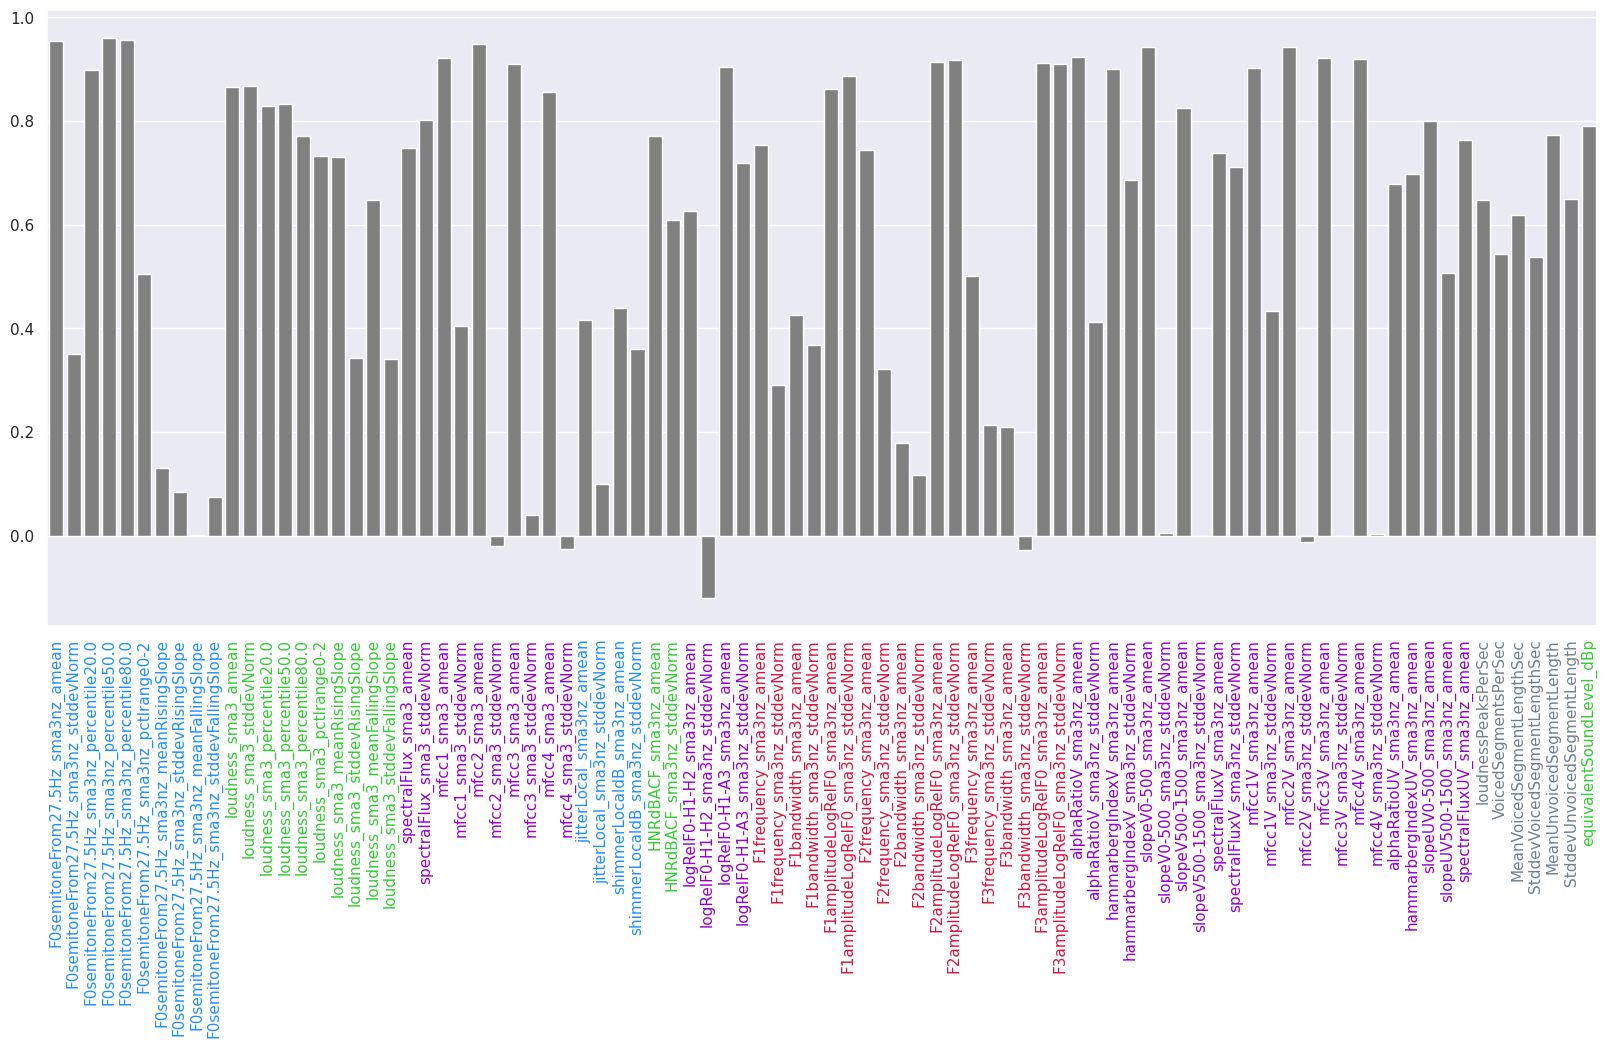

In [ ]:
print(en_errors_r_squared)
color_bar_plot(y=en_errors_r_squared, sort=False)


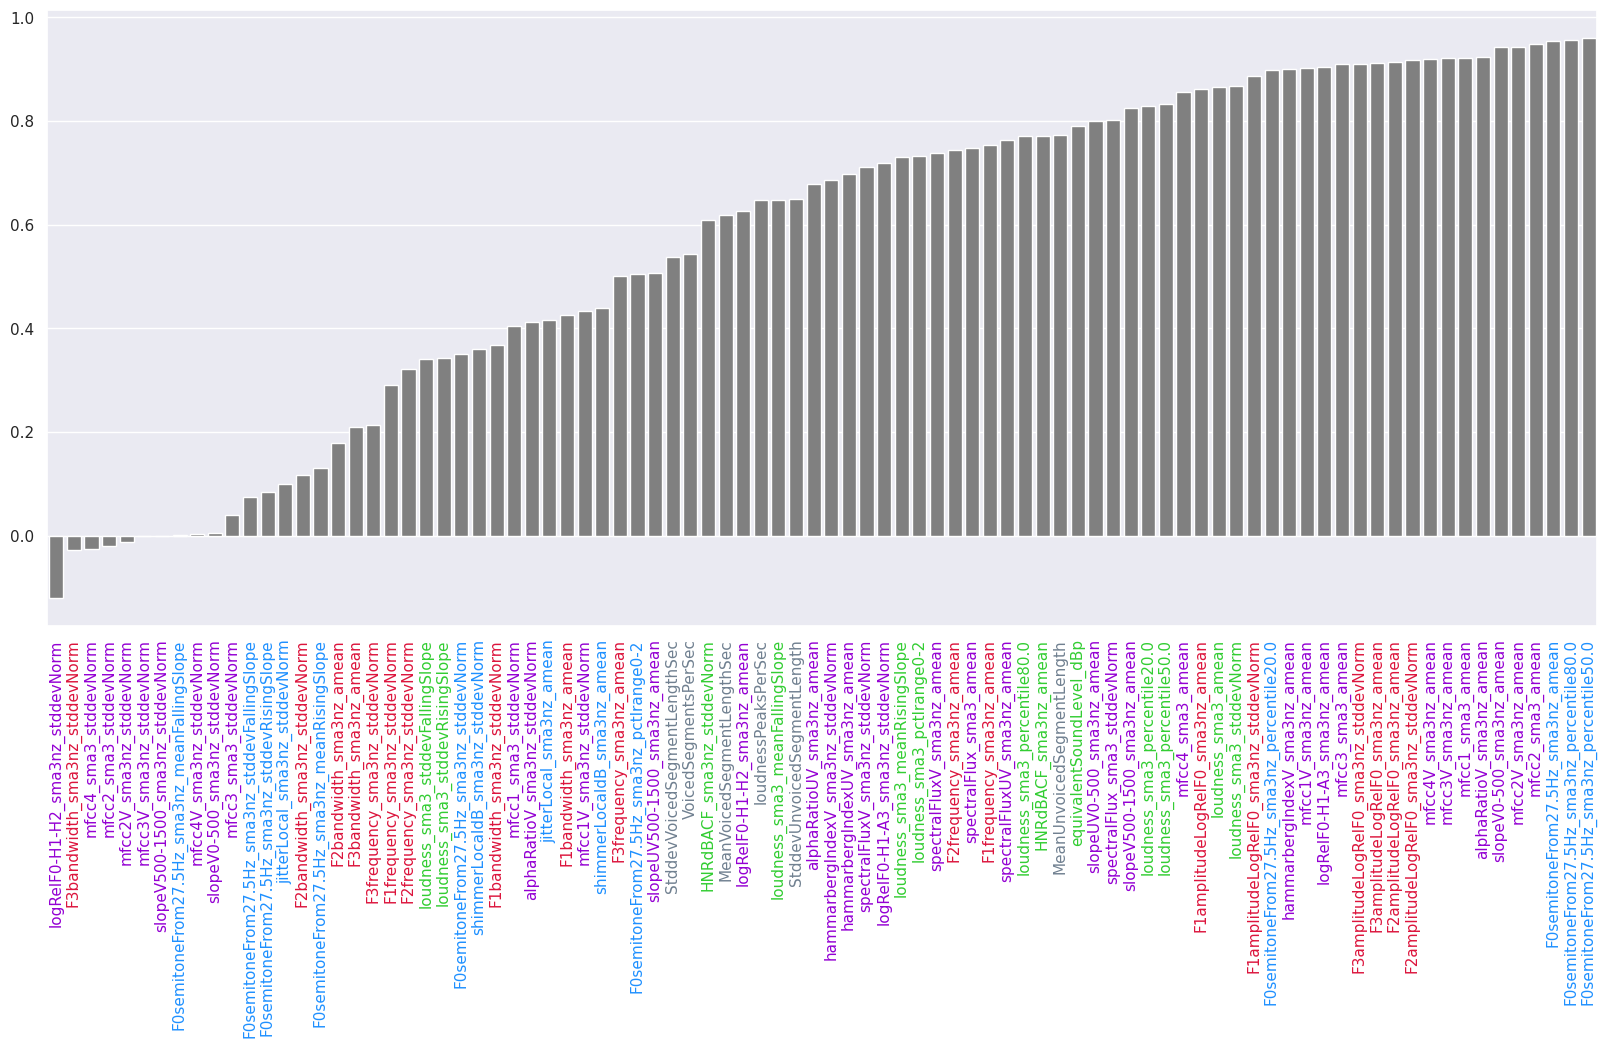

In [ ]:
color_bar_plot(y=en_errors_r_squared, sort=True)

# Random Forest

In [ ]:
rf_errors_r_squared = []
for i in tqdm(range(88)):
  rf_r_squared = pipeline(normalised_embeddings_hybrid_byols, normalised_embeddings_egemaps[:,i], regression_model='rf')
  rf_errors_r_squared.append(rf_r_squared)

 32%|███▏      | 28/88 [1:41:55<4:01:52, 241.87s/it]

In [ ]:
color_bar_plot(y=rf_errors_r_squared, sort=False)


In [ ]:
color_bar_plot(y=rf_errors_r_squared, sort=True)


# MLP

In [ ]:
mlp_errors_r_squared = []
for i in tqdm(range(88)):
  mlp_r_squared = pipeline(normalised_embeddings_hybrid_byols, normalised_embeddings_egemaps[:,i], regression_model='mlp')
  mlp_errors_r_squared.append(mlp_r_squared)

In [ ]:
color_bar_plot(y=mlp_errors_r_squared, sort=False)


In [ ]:
color_bar_plot(y=mlp_errors_r_squared, sort=True)


# Importance in Hybrid BYOLS

In [ ]:
importance_order = ['1467', '93', '1482', '356', '803', '1525', '18', '760', '495', '1483', '418', '677', '1125', '1227', '1850', '41', '1560', '1348', '1883', '223', '1078', '1023', '1407', '1440', '191', '421', '732', '776', '47', '1138', '1063', '1086', '170', '259', '361', '768', '1085', '1649', '2029', '580', '1239', '1374', '1032', '46', '2010', '937', '1081', '1136', '1132', '1143', '1739', '1855', '109', '1638', '2021', '231', '485', '954', '1112', '1650', '1765', '1031', '427', '1931', '605', '1324', '1996', '1162', '49', '548', '12', '218', '280', '318', '344', '412', '451', '746', '841', '1043', '1212', '1272', '1350', '1411', '1518', '1821', '1189', '161', '785', '452', '499', '1780', '1583', '1191', '211', '320', '1451', '1102', '1562', '1982', '1211', '1056', '1088', '61', '260', '535', '982', '1160', '1369', '1045', '57', '136', '185', '276', '424', '697', '771', '914', '1430', '1647', '1827', '648', '991', '1970', '583', '810', '1131', '1257', '1327', '1969', '887', '1037', '1108', '148', '1089', '867', '407', '507', '1367', '1479', '1919', '2009', '69', '75', '154', '351', '388', '664', '828', '901', '959', '1073', '1133', '1254', '1300', '1323', '1472', '1504', '1730', '1807', '1881', '1993', '1892', '345', '529', '1601', '1419', '209', '332', '534', '878', '355', '1236', '1094', '1539', '1215', '1399', '21', '476', '487', '1698', '1082', '335', '124', '275', '313', '415', '504', '581', '699', '702', '779', '1049', '1090', '1506', '1629', '1683', '1207', '1232', '2037', '241', '1573', '717', '368', '756', '637', '675', '1163', '1371', '1824', '1259', '939', '1042', '1302', '1741', '620', '1444', '1720', '1244', '1906', '1005', '1334', '549', '1535', '1653', '1772', '517', '1679', '1854', '1957', '1980', '2016', '32', '174', '176', '217', '246', '353', '357', '391', '435', '466', '481', '544', '596', '658', '770', '879', '909', '964', '984', '1178', '1188', '1258', '1274', '1316', '1370', '1373', '1393', '1424', '1468', '1529', '1553', '1609', '1718', '1734', '1762', '1810', '1851', '1859', '1869', '1902', '1909', '1933', '1983', '2002', '2017', '524', '985', '465', '478', '1234', '1243', '279', '365', '437', '900', '1521', '1634', '55', '126', '227', '289', '354', '380', '381', '941', '1265', '1412', '1471', '1617', '1711', '1748', '1853', '81', '486', '281', '1270', '1915', '1059', '1542', '852', '1061', '4', '28', '152', '173', '177', '226', '300', '310', '386', '398', '417', '652', '685', '689', '708', '772', '794', '805', '825', '877', '934', '945', '976', '1011', '1014', '1106', '1140', '1209', '1216', '1240', '1271', '1312', '1330', '1475', '1541', '1546', '1547', '1568', '1585', '1639', '1641', '1726', '1731', '1775', '1839', '2040', '1046', '103', '1071', '1275', '1519', '97', '526', '736', '1171', '1783', '1904', '933', '1392', '1074', '753', '660', '416', '1469', '1233', '108', '149', '1268', '60', '472', '709', '1039', '1053', '1064', '1077', '1083', '1206', '1229', '1361', '1676', '1684', '369', '2045', '250', '946', '1029', '390', '1380', '1457', '1543', '1574', '1590', '1673', '1863', '100', '122', '155', '219', '253', '311', '378', '392', '456', '458', '475', '570', '584', '585', '593', '631', '639', '653', '654', '687', '738', '777', '790', '813', '824', '869', '893', '899', '926', '930', '931', '978', '1047', '1052', '1070', '1095', '1097', '1115', '1129', '1146', '1147', '1213', '1237', '1238', '1261', '1277', '1297', '1363', '1376', '1441', '1477', '1491', '1494', '1496', '1510', '1514', '1517', '1555', '1593', '1664', '1671', '1681', '1688', '1695', '1706', '1774', '1816', '1835', '1860', '1897', '1914', '1975', '1988', '2003', '2013', '2036', '347', '1515', '1903', '1202', '1397', '1307', '6', '215', '230', '566', '789', '1033', '1228', '1403', '1421', '1628', '1817', '1829', '1946', '755', '1231', '1484', '0', '15', '17', '37', '53', '58', '63', '79', '80', '131', '142', '204', '282', '299', '333', '341', '350', '360', '399', '409', '420', '433', '450', '477', '483', '490', '506', '522', '547', '564', '576', '586', '616', '625', '649', '706', '807', '864', '872', '880', '894', '906', '917', '986', '1001', '1002', '1003', '1065', '1080', '1150', '1176', '1201', '1203', '1222', '1246', '1248', '1263', '1292', '1311', '1320', '1337', '1357', '1375', '1384', '1386', '1400', '1456', '1499', '1500', '1509', '1523', '1528', '1544', '1550', '1557', '1577', '1595', '1597', '1616', '1621', '1656', '1686', '1692', '1700', '1707', '1727', '1759', '1760', '1792', '1803', '1815', '1833', '1867', '1876', '1899', '1901', '1964', '1979', '2027', '2041', '1939', '1898', '364', '1062', '192', '1537', '2007', '78', '1314', '1428', '189', '538', '688', '737', '1024', '1569', '1632', '1714', '1', '484', '611', '913', '1352', '2030', '1396', '859', '1563', '1622', '993', '121', '367', '1977', '324', '214', '376', '1221', '98', '213', '1661', '1838', '1394', '203', '240', '455', '553', '558', '1187', '1492', '1870', '1771', '1442', '429', '567', '1130', '1225', '1235', '1750', '1763', '9', '10', '24', '26', '27', '29', '30', '31', '34', '35', '38', '48', '50', '51', '56', '59', '65', '76', '82', '85', '87', '88', '90', '96', '99', '107', '113', '123', '144', '160', '166', '169', '175', '181', '188', '194', '195', '196', '197', '200', '206', '220', '225', '233', '237', '242', '247', '248', '257', '258', '261', '264', '265', '271', '286', '293', '294', '295', '303', '304', '315', '316', '322', '325', '327', '328', '331', '334', '336', '348', '349', '359', '363', '366', '370', '371', '373', '374', '382', '395', '396', '400', '403', '404', '414', '419', '426', '430', '431', '436', '439', '442', '445', '447', '459', '461', '462', '468', '473', '479', '482', '488', '489', '491', '500', '501', '502', '515', '516', '518', '520', '523', '525', '527', '528', '530', '533', '537', '541', '543', '545', '551', '552', '554', '555', '559', '560', '562', '565', '573', '575', '577', '578', '579', '588', '589', '590', '591', '592', '607', '609', '612', '613', '617', '622', '624', '627', '630', '642', '643', '646', '647', '651', '657', '661', '662', '665', '666', '667', '669', '673', '682', '686', '691', '693', '696', '700', '701', '707', '711', '715', '718', '726', '727', '728', '730', '731', '739', '742', '747', '748', '757', '759', '762', '764', '769', '778', '781', '783', '795', '798', '799', '801', '802', '812', '814', '826', '827', '842', '845', '846', '848', '853', '855', '862', '868', '881', '883', '884', '885', '888', '895', '896', '905', '912', '915', '916', '921', '922', '925', '928', '929', '936', '938', '940', '943', '944', '947', '948', '950', '953', '955', '962', '963', '967', '969', '972', '979', '980', '981', '990', '992', '994', '997', '1004', '1006', '1007', '1008', '1012', '1013', '1020', '1021', '1026', '1034', '1036', '1048', '1050', '1051', '1058', '1060', '1067', '1068', '1072', '1076', '1091', '1098', '1100', '1103', '1104', '1105', '1107', '1110', '1114', '1117', '1118', '1124', '1127', '1128', '1135', '1137', '1142', '1144', '1149', '1170', '1173', '1175', '1179', '1183', '1190', '1192', '1194', '1196', '1198', '1199', '1200', '1204', '1217', '1218', '1223', '1241', '1245', '1251', '1252', '1253', '1255', '1260', '1264', '1267', '1273', '1278', '1279', '1286', '1290', '1293', '1301', '1303', '1305', '1315', '1318', '1319', '1321', '1325', '1335', '1336', '1340', '1341', '1343', '1347', '1349', '1353', '1358', '1360', '1362', '1366', '1372', '1379', '1382', '1383', '1387', '1388', '1391', '1398', '1408', '1409', '1410', '1413', '1414', '1415', '1418', '1425', '1432', '1433', '1446', '1449', '1450', '1453', '1455', '1459', '1460', '1461', '1462', '1464', '1474', '1487', '1490', '1503', '1507', '1512', '1522', '1526', '1527', '1531', '1532', '1538', '1545', '1549', '1551', '1552', '1558', '1567', '1571', '1578', '1588', '1589', '1598', '1599', '1600', '1602', '1603', '1604', '1605', '1610', '1612', '1614', '1615', '1624', '1626', '1631', '1633', '1644', '1646', '1659', '1660', '1663', '1668', '1669', '1670', '1675', '1678', '1682', '1687', '1691', '1702', '1710', '1735', '1743', '1744', '1745', '1747', '1749', '1751', '1756', '1758', '1769', '1776', '1777', '1779', '1782', '1794', '1798', '1800', '1802', '1809', '1823', '1826', '1828', '1831', '1832', '1840', '1841', '1842', '1848', '1852', '1856', '1864', '1874', '1877', '1878', '1880', '1882', '1884', '1885', '1887', '1889', '1890', '1896', '1900', '1910', '1917', '1920', '1921', '1922', '1924', '1925', '1927', '1928', '1930', '1935', '1937', '1943', '1947', '1952', '1953', '1954', '1955', '1956', '1959', '1961', '1965', '1971', '1994', '2012', '2015', '2018', '2019', '2022', '2023', '2028', '2035', '2038', '1989', '210', '1820', '186', '556', '724', '774', '1018', '1116', '64', '86', '180', '187', '298', '385', '425', '532', '561', '636', '716', '782', '876', '919', '961', '968', '971', '1426', '1465', '1657', '1693', '1790', '1918', '1929', '1985', '2025', '2032', '1843', '337', '402', '1648', '1195', '105', '1908', '1402', '1498', '1753', '1757', '822', '1513', '1958', '101', '141', '302', '326', '448', '663', '681', '815', '837', '844', '1000', '1027', '1109', '1159', '1164', '1288', '1306', '1309', '1416', '1423', '1530', '1533', '1565', '1651', '1697', '1703', '1722', '1767', '1804', '1936', '1974', '3', '600', '1219', '1548', '1875', '171', '184', '228', '1808', '1256', '1054', '1811', '608', '1152', '1938', '7', '234', '342', '519', '752', '804', '975', '1287', '1333', '1508', '1559', '1973', '2020', '2031', '1284', '1962', '960', '1699', '1536', '1704', '245', '1635', '1672', '1721', '871', '1435', '1478', '270', '1689', '2042', '138', '1346', '1785', '1987', '956', '1857', '2046', '263', '278', '467', '744', '786', '830', '849', '1168', '1208', '1990', '5', '20', '22', '70', '84', '94', '104', '106', '116', '118', '128', '130', '157', '163', '182', '183', '205', '208', '212', '236', '251', '252', '267', '301', '305', '309', '312', '317', '319', '338', '340', '387', '393', '394', '405', '406', '434', '441', '480', '505', '511', '531', '540', '546', '563', '587', '597', '603', '614', '621', '678', '683', '695', '703', '705', '714', '720', '722', '729', '745', '765', '767', '775', '780', '784', '819', '820', '823', '832', '838', '840', '843', '847', '851', '857', '858', '860', '870', '874', '897', '904', '910', '911', '923', '924', '935', '951', '958', '973', '1015', '1016', '1038', '1040', '1044', '1075', '1084', '1092', '1096', '1111', '1120', '1123', '1134', '1148', '1151', '1155', '1157', '1167', '1177', '1184', '1205', '1250', '1295', '1304', '1326', '1328', '1331', '1339', '1359', '1378', '1390', '1406', '1429', '1431', '1434', '1436', '1437', '1438', '1447', '1448', '1454', '1463', '1480', '1485', '1489', '1501', '1511', '1534', '1556', '1576', '1591', '1606', '1607', '1618', '1623', '1637', '1640', '1654', '1655', '1677', '1709', '1712', '1716', '1761', '1768', '1773', '1781', '1786', '1787', '1806', '1836', '1845', '1846', '1858', '1861', '1871', '1872', '1886', '1893', '1913', '1942', '1944', '1945', '1948', '1949', '1972', '1992', '1999', '2001', '2008', '2024', '2026', '2033', '1923', '1642', '119', '401', '1101', '1365', '1458', '1662', '1986', '1997', '132', '147', '164', '377', '503', '615', '635', '725', '861', '1030', '1166', '1385', '1587', '1666', '1395', '1645', '232', '513', '151', '1968', '470', '36', '256', '362', '422', '539', '602', '692', '735', '741', '890', '927', '1019', '1066', '1126', '1169', '1356', '1443', '1495', '1524', '1665', '1694', '1724', '1754', '1819', '1822', '179', '323', '679', '1057', '1298', '1420', '1566', '1981', '1596', '207', '249', '492', '1849', '150', '262', '1099', '1141', '1182', '1680', '1705', '1912', '13', '449', '1174', '1473', '1220', '1592', '1728', '8', '634', '1795', '920', '165', '1561', '292', '1022', '1041', '1342', '273', '291', '568', '1139', '102', '836', '983', '1940', '1967', '713', '143', '283', '379', '569', '582', '618', '811', '1172', '1181', '1214', '1439', '1502', '1813', '1905', '1932', '45', '62', '72', '77', '95', '110', '127', '135', '153', '158', '159', '168', '216', '222', '229', '255', '284', '285', '290', '296', '339', '358', '375', '440', '444', '454', '457', '494', '496', '508', '510', '512', '521', '550', '557', '594', '598', '599', '601', '604', '629', '644', '645', '659', '690', '694', '710', '721', '733', '740', '743', '763', '766', '792', '797', '800', '806', '808', '809', '817', '818', '831', '833', '839', '850', '856', '886', '889', '903', '942', '970', '974', '988', '998', '1009', '1028', '1035', '1093', '1145', '1165', '1197', '1224', '1226', '1230', '1247', '1262', '1266', '1276', '1282', '1294', '1296', '1299', '1329', '1354', '1364', '1377', '1381', '1401', '1452', '1470', '1516', '1554', '1586', '1594', '1608', '1611', '1619', '1636', '1696', '1701', '1713', '1717', '1723', '1737', '1766', '1770', '1778', '1788', '1789', '1791', '1793', '1805', '1830', '1847', '1865', '1873', '1879', '1894', '1907', '1916', '1926', '1941', '1963', '1995', '2005', '2011', '2014', '2047', '471', '1764', '54', '115', '352', '750', '892', '1417', '1476', '650', '343', '882', '865', '1505', '346', '39', '52', '235', '254', '432', '453', '734', '863', '1658', '1834', '2034', '40', '120', '129', '140', '474', '638', '821', '999', '1069', '1581', '1625', '1732', '2043', '145', '306', '788', '2044', '67', '202', '793', '1079', '1579', '1796', '1950', '23', '162', '640', '989', '1193', '92', '1960', '1814', '1837', '1891', '2039', '1784', '73', '221', '224', '274', '536', '835', '1283', '1322', '1368', '1582', '1729', '1868', '14', '33', '83', '91', '114', '125', '133', '190', '193', '198', '238', '243', '268', '272', '277', '287', '307', '383', '410', '423', '428', '438', '464', '493', '514', '542', '574', '619', '632', '633', '641', '656', '668', '671', '672', '684', '698', '712', '723', '787', '796', '829', '866', '875', '891', '902', '907', '908', '932', '952', '965', '966', '977', '987', '995', '1055', '1087', '1119', '1154', '1158', '1161', '1185', '1186', '1249', '1281', '1291', '1310', '1313', '1332', '1351', '1355', '1389', '1404', '1445', '1564', '1575', '1613', '1690', '1725', '1733', '1746', '1752', '1951', '1966', '1976', '1978', '1520', '314', '1010', '1121', '66', '111', '172', '308', '509', '572', '606', '674', '719', '873', '1025', '1497', '1572', '1911', '1991', '2004', '112', '239', '329', '408', '655', '1122', '1620', '1895', '1289', '1570', '1708', '1308', '2', '11', '16', '19', '42', '43', '44', '71', '117', '137', '146', '156', '199', '201', '244', '269', '288', '330', '397', '413', '443', '463', '497', '498', '571', '626', '628', '749', '751', '754', '761', '791', '816', '834', '898', '918', '957', '1017', '1113', '1153', '1210', '1242', '1269', '1317', '1344', '1345', '1405', '1422', '1427', '1466', '1486', '1488', '1540', '1580', '1584', '1627', '1630', '1652', '1667', '1674', '1715', '1719', '1736', '1755', '1812', '1862', '1866', '1888', '1934', '1998', '2000', '25', '74', '89', '134', '167', '266', '384', '469', '610', '758', '773', '1156', '1338', '1685', '1740', '68', '139', '178', '297', '321', '372', '389', '411', '446', '460', '595', '623', '670', '676', '680', '704', '854', '949', '996', '1180', '1280', '1285', '1481', '1493', '1643', '1738', '1742', '1797', '1799', '1801', '1818', '1825', '1844', '1984', '2006']

importance_order = importance_order[::-1]
importance_order = [int(i) for i in importance_order]
print(importance_order)

# Getting performance for 20

In [ ]:
importance_order_20 = importance_order[:20]
print(importance_order_20)

en_errors_r_squared = []

for i in tqdm(range(88)):
  en_r_squared = pipeline(normalised_embeddings_hybrid_byols.numpy()[:, importance_order_20], normalised_embeddings_egemaps[:,i], regression_model='elasticnet')
  en_errors_r_squared.append(en_r_squared)

In [ ]:
color_bar_plot(y=en_errors_r_squared, sort=True)


# Getting performance for top 100

In [ ]:
importance_order_100 = importance_order[:100]
print(importance_order_100)

en_errors_r_squared = []

print(normalised_embeddings_hybrid_byols.numpy().shape)
print(normalised_embeddings_hybrid_byols.numpy()[:, importance_order_100].shape)
for i in tqdm(range(88)):

  en_r_squared = pipeline(normalised_embeddings_hybrid_byols.numpy()[:, importance_order_100], normalised_embeddings_egemaps[:,i], regression_model='elasticnet')
  en_errors_r_squared.append(en_r_squared)


In [ ]:
color_bar_plot(y=en_errors_r_squared, sort=True)


# Descriptive Statistics

In [ ]:
required_labels = ['W', 'L', 'E', 'A', 'F', 'T', 'N']

anger_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='W')[0],:]
bored_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='L')[0],:]
disgust_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='E')[0],:]
fear_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='A')[0],:]
happy_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='F')[0],:]
sad_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='T')[0],:]
neutral_embeddings = normalised_embeddings_egemaps[np.where(np.array(labels)=='N')[0],:]


In [ ]:
color_to_feature_category_dict = {'dodgerblue': 'vocal_folds', 'crimson': 'vocal_tract', 'limegreen': 'intensity', 'darkviolet': 'spectral', 'slategrey': 'prosodic'}

def descriptive_box_plot(feature_number):
  feature_name = egemaps_feature_names[feature_number]
  data = [anger_embeddings[:,feature_number], bored_embeddings[:, feature_number], disgust_embeddings[:, feature_number], fear_embeddings[:, feature_number], happy_embeddings[:, feature_number], sad_embeddings[:, feature_number], neutral_embeddings[:, feature_number]]
  fig, ax = plt.subplots(figsize=(10,4))
  ax.set_title(feature_name+ ' '+color_to_feature_category_dict[egemaps_category_dict[feature_name]])
  ax.boxplot(data)
  ax.set_xticklabels(['ANG', 'BOR', 'DIS', 'FEA', 'HAP', 'SAD', 'NEU'])


### Plots

In [ ]:
for i in range(88):
  if egemaps_category_dict[egemaps_feature_names[i]]=='dodgerblue':
    descriptive_box_plot(i)

In [ ]:
for i in range(88):
  if egemaps_category_dict[egemaps_feature_names[i]]=='crimson':
    descriptive_box_plot(i)

In [ ]:
for i in range(88):
  if egemaps_category_dict[egemaps_feature_names[i]]=='limegreen':
    descriptive_box_plot(i)

In [ ]:
for i in range(88):
  if egemaps_category_dict[egemaps_feature_names[i]]=='darkviolet':
    descriptive_box_plot(i)

In [ ]:
for i in range(88):
  if egemaps_category_dict[egemaps_feature_names[i]]=='slategrey':
    descriptive_box_plot(i)

### Effect size

In [ ]:
def effectsize(dist1, dist2):
  mean1, mean2 = np.mean(dist1), np.mean(dist2)
  std1, std2 = np.std(dist1, ddof=1), np.std(dist2, ddof=1)
  pooled_std = np.sqrt(((len(dist1)-1)*std1**2 + (len(dist2)-1)*std2**2) / (len(dist1) + len(dist2) - 2))
  cohens_d = (mean2 - mean1) / pooled_std
  return cohens_d


In [ ]:
from scipy import stats

anger_neutral_effect_size_list = []
for i in range(88):
  anger_neutral_effect_size_list.append(abs(effectsize(anger_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=anger_neutral_effect_size_list, sort=True)

In [ ]:
bored_neutral_effect_size_list = []
for i in range(88):
  bored_neutral_effect_size_list.append(abs(effectsize(bored_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=bored_neutral_effect_size_list, sort=True)

In [ ]:
disgust_neutral_effect_size_list = []
for i in range(88):
  disgust_neutral_effect_size_list.append(abs(effectsize(disgust_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=disgust_neutral_effect_size_list, sort=True)

In [ ]:
fear_neutral_effect_size_list = []
for i in range(88):
  fear_neutral_effect_size_list.append(abs(effectsize(fear_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=fear_neutral_effect_size_list, sort=True)

In [ ]:
happy_neutral_effect_size_list = []
for i in range(88):
  happy_neutral_effect_size_list.append(abs(effectsize(happy_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=happy_neutral_effect_size_list, sort=True)

In [ ]:
sad_neutral_effect_size_list = []
for i in range(88):
  sad_neutral_effect_size_list.append(abs(effectsize(sad_embeddings[:,i].numpy(), neutral_embeddings[:, i].numpy())))

color_bar_plot(y=sad_neutral_effect_size_list, sort=True)

# Calculate Importance


In [ ]:
X=normalised_embeddings_hybrid_byols
y=labels

Rank 1: Feature 500 - Importance Score: 0.010317749126360173
Rank 2: Feature 27 - Importance Score: 0.008945701228470045
Rank 3: Feature 1447 - Importance Score: 0.008013352349915938
Rank 4: Feature 152 - Importance Score: 0.007603650346134636
Rank 5: Feature 30 - Importance Score: 0.007311243393903182
Rank 6: Feature 169 - Importance Score: 0.007206461085636362
Rank 7: Feature 935 - Importance Score: 0.006911229375227593
Rank 8: Feature 652 - Importance Score: 0.006451849720969813
Rank 9: Feature 88 - Importance Score: 0.00591596690552337
Rank 10: Feature 44 - Importance Score: 0.005773962441529592
Rank 11: Feature 423 - Importance Score: 0.005701115042297661
Rank 12: Feature 712 - Importance Score: 0.005551087705906181
Rank 13: Feature 300 - Importance Score: 0.005427385063454196
Rank 14: Feature 1224 - Importance Score: 0.005324500988975451
Rank 15: Feature 248 - Importance Score: 0.0052484310394175305
Rank 16: Feature 1372 - Importance Score: 0.005227275188545854
Rank 17: Feature 2

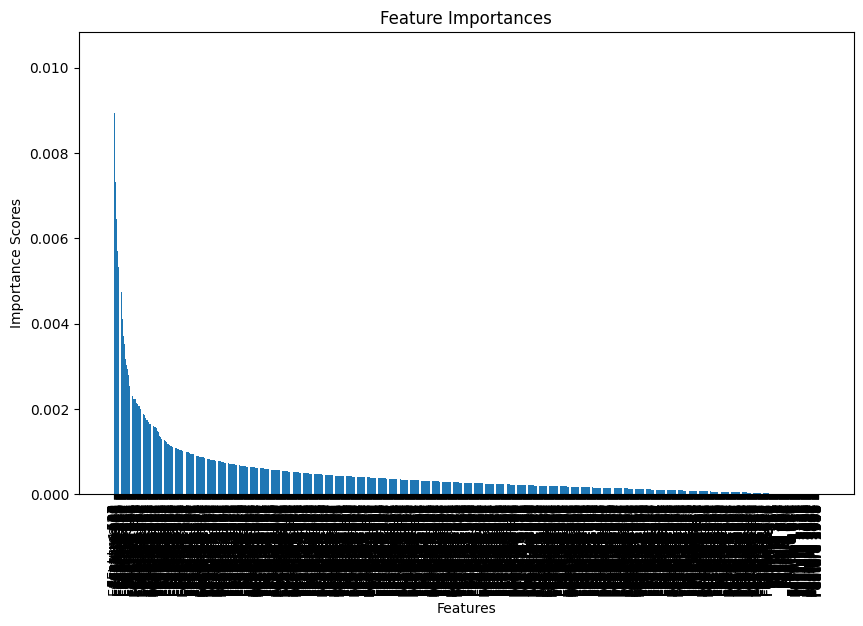

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Assuming you have your feature data `X` and target labels `y`

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Get feature importance scores
importance_scores = clf.feature_importances_

# Create a list of features with their corresponding importance scores
feature_names = [f"Feature {i}" for i in range(X.shape[1])]
feature_importances = [(feature, score) for feature, score in zip(feature_names, importance_scores)]

# Sort the list in descending order based on importance scores
feature_importances.sort(key=lambda x: x[1], reverse=True)

# Print the features ranked by importance
for rank, (feature, score) in enumerate(feature_importances, start=1):
    print(f"Rank {rank}: {feature} - Importance Score: {score}")

# Create a bar plot of feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), [score for _, score in feature_importances])
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importances')
plt.xticks(range(len(feature_importances)), [feature for feature, _ in feature_importances], rotation=90)
plt.show()

# Return the list of features ranked by importance
ranked_features = [feature for feature, _ in feature_importances]


In [ ]:
print(ranked_features)

['Feature 500', 'Feature 27', 'Feature 1447', 'Feature 152', 'Feature 30', 'Feature 169', 'Feature 935', 'Feature 652', 'Feature 88', 'Feature 44', 'Feature 423', 'Feature 712', 'Feature 300', 'Feature 1224', 'Feature 248', 'Feature 1372', 'Feature 29', 'Feature 391', 'Feature 159', 'Feature 1736', 'Feature 590', 'Feature 1435', 'Feature 1051', 'Feature 396', 'Feature 762', 'Feature 1459', 'Feature 63', 'Feature 781', 'Feature 749', 'Feature 141', 'Feature 817', 'Feature 629', 'Feature 1971', 'Feature 125', 'Feature 305', 'Feature 287', 'Feature 1924', 'Feature 1437', 'Feature 419', 'Feature 860', 'Feature 465', 'Feature 17', 'Feature 643', 'Feature 293', 'Feature 218', 'Feature 452', 'Feature 111', 'Feature 252', 'Feature 317', 'Feature 842', 'Feature 488', 'Feature 1594', 'Feature 162', 'Feature 247', 'Feature 274', 'Feature 266', 'Feature 404', 'Feature 1605', 'Feature 790', 'Feature 144', 'Feature 150', 'Feature 0', 'Feature 1036', 'Feature 1999', 'Feature 373', 'Feature 1053', 'Fe